In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from Utilities import LogDataset
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
from multiprocessing import shared_memory

data_ = pd.read_csv(r"Dataset/out/parsed_HDFS_.log_structured.csv").values
data_shared_memory = shared_memory.SharedMemory(create=True, size=data_.nbytes)
data_np = np.ndarray(data_.shape, dtype=data_.dtype, buffer=data_shared_memory.buf)
np.copyto(data_np, data_)

C:\Users\hosse\AppData\Local\Temp\ipykernel_25384\2729602440.py:3: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ = pd.read_csv(r"Dataset/out/parsed_HDFS_.log_structured.csv").values


In [3]:
dataset = LogDataset(400, shared_memory=data_np)
temp = [i * 400 * 2 + 100 for i in range(len(dataset) // 900)]
np.random.shuffle(temp)
train_idx, test_idx = temp[:int(len(temp) * 0.8)], temp[int(len(temp) * 0.8):]
train_idx = np.array([i + j for i in train_idx for j in range(100)])
test_idx = np.array([i + j for i in test_idx for j in range(100)])
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

len(train_dataset), len(test_dataset)

(193600, 48500)

In [4]:
from transformers import BertConfig, BertModel


class CustomBERT(nn.Module):
    def __init__(self, class_elements=7, logit_elements=2, hidden=3, token_count=400, class_count=400):
        super(CustomBERT, self).__init__()
        self.device = 'cpu'
        self.class_elements = class_elements
        self.logit_elements = logit_elements
        self.all_elements = class_elements + logit_elements
        self.hidden = hidden
        self.token_size = token_count
        self.class_count = class_count
        self.bert_model = BertModel(BertConfig(
            hidden_size=hidden * self.all_elements,
            num_hidden_layers=4,
            num_attention_heads=self.all_elements,
            intermediate_size=400,
            type_vocab_size=1,
            max_position_embeddings=token_count,
        )).to(float)

        self.mask_emb = nn.Parameter(torch.randn(self.all_elements * hidden)).to(float)

        self.embeddings = [nn.Embedding(class_count + 1, hidden, padding_idx=class_count).to(float) for _ in
                           range(class_elements)]
        self.linear_vec = [nn.Linear(1, hidden).to(float) for _ in range(logit_elements)]

        self.position_embeddings = nn.Embedding(token_count, self.all_elements * hidden)

        self.position_ids = torch.arange(token_count).to(int)

        self.class_projector_head = [nn.Linear(hidden, class_count).to(float) for i in range(self.class_elements)]
        self.logit_projector_head = [nn.Linear(hidden, 1).to(float) for i in range(self.logit_elements)]

    def to(self, *args, **kwargs):
        self.device = args[0]
        self.bert_model = self.bert_model.to(*args, **kwargs)
        self.mask_emb = self.mask_emb.to(*args, **kwargs)
        self.embeddings = [embedding.to(*args, **kwargs) for embedding in self.embeddings]
        self.linear_vec = [linear.to(*args, **kwargs) for linear in self.linear_vec]
        self.position_embeddings = self.position_embeddings.to(*args, **kwargs)
        self.position_ids = self.position_ids.to(*args, **kwargs).to(int)
        self.class_projector_head = [head.to(*args, **kwargs) for head in self.class_projector_head]
        self.logit_projector_head = [head.to(*args, **kwargs) for head in self.logit_projector_head]
        return super().to(*args, **kwargs)

    def forward(self, x):
        x = ([self.embeddings[i](x[0][:, :, i]) for i in range(self.class_elements)] +
             [self.linear_vec[i](x[1][:, :, i].unsqueeze(2)) for i in range(self.logit_elements)])
        x = torch.cat(x, dim=2)

        position_embeddings = self.position_ids.unsqueeze(0).expand_as(x[:, :, 0])  # (batch_size, seq_length)
        position_embeddings = self.position_embeddings(position_embeddings)  # (batch_size, seq_length, hidden_size)
        x[:, x.shape[1] // 2:] = self.mask_emb
        x = x + position_embeddings

        x = self.bert_model(inputs_embeds=x, attention_mask=torch.ones(x.shape[:-1]).to(float).to(self.device))

        x = x.last_hidden_state
        x = torch.split(x, self.hidden, dim=2)
        x = (torch.stack(
            [F.softmax(self.class_projector_head[i](x[i]), dim=2) for i in range(self.class_elements)]).transpose(1,
                                                                                                                  0).transpose(
            1, 2),
             torch.stack([F.sigmoid(self.logit_projector_head[i](x[self.class_elements + i])) for i in
                          range(self.logit_elements)]).transpose(1, 0).transpose(1, 2))
        return x

    def remove_unattended(self, batch_vectors, attention_mask):
        return [batch_vectors[i][attention_mask[i] == 1] for i in range(len(batch_vectors))]


with torch.no_grad():
    _, _, temp, temp2 = next(
        iter(torch.utils.data.DataLoader(dataset, batch_size=3, collate_fn=dataset.collate_fn, shuffle=True)))
    res = CustomBERT().forward(temp)
print()
temp2[0].shape, res[0].shape, temp[0].shape, " ", temp2[1].shape, res[1].shape, temp[1].shape

(torch.Size([3, 400, 7, 400]),
 torch.Size([3, 400, 7, 400]),
 torch.Size([3, 400, 7]),
 ' ',
 torch.Size([3, 400, 2, 1]),
 torch.Size([3, 400, 2, 1]),
 torch.Size([3, 400, 2]))

In [24]:
import pytorch_lightning as pl
from torch.optim import Adam


class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CustomBERT()
        self.criterion_class = nn.CrossEntropyLoss()
        self.criterion_scaler = nn.MSELoss()
        self.loss_history = [[], []]

    def to(self, *args, **kwargs):
        self.model = self.model.to(*args, **kwargs)
        return super().to(*args, **kwargs)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        _, _, (data_class, data_scaler), (loss_data_class, loss_data_scaler) = batch
        idx = data_class.shape[1] // 2
        outputs_class, outputs_scaler = self((data_class.to(self.device), data_scaler.to(self.device).to(float)))

        outputs_class, loss_data_class = outputs_class[:, idx], loss_data_class[:, idx].to(self.device).to(float)
        loss1 = torch.sum(torch.stack([
            self.criterion_class(outputs_class[:, i, :], loss_data_class[:, i, :]) * j
            for i, j in zip(list(range(7)), [0.5, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05])
        ])) /6 * 0.997

        outputs_scaler, loss_data_scaler = outputs_scaler[:, idx], loss_data_scaler[:, idx].to(self.device).to(float)
        loss2 = self.criterion_scaler(outputs_scaler, loss_data_scaler) *8 * 0.003 

        # self.log('class_loss', loss1)
        # self.log('scaler_loss', loss2)
        if batch_idx%10==0:
            self.loss_history[0].append(loss1.item()/10)
            self.loss_history[1].append(loss2.item()/10)
        else:
            self.loss_history[0][-1] += loss1.item()/10
            self.loss_history[1][-1] += loss2.item()/10
        return loss1 + loss2

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-0)
        return optimizer


model = LitModel().to(float).to('cuda')
trainer = pl.Trainer(accumulate_grad_batches=10, max_epochs=10)
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=30, 
                collate_fn=dataset.collate_fn, shuffle=True, num_workers=6, persistent_workers=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(model, data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | CustomBERT       | 947 K 
1 | criterion_class  | CrossEntropyLoss | 0     
2 | criterion_scaler | MSELoss          | 0     
------------------------------------------------------
947 K     Trainable params
0         Non-trainable params
947 K     Total params
3.789     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

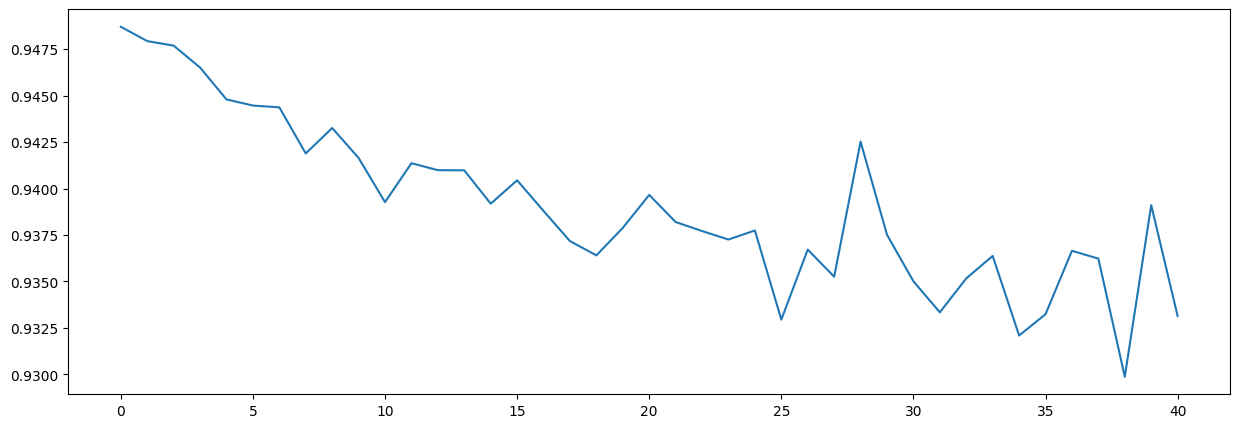

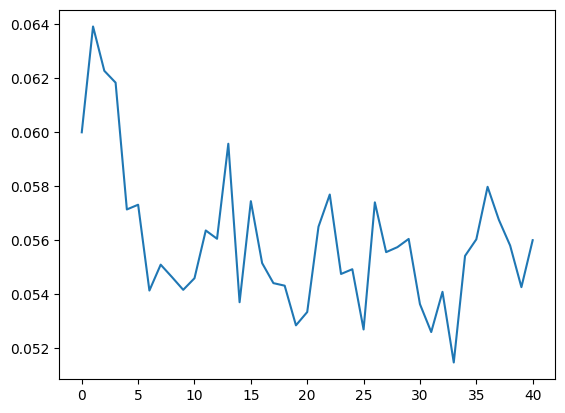

In [26]:
# plot the loss
plt.figure(figsize=(15,5))
plt.plot(np.array(model.loss_history[0][1:-1]))
plt.show()
plt.plot(np.array(model.loss_history[1][1:-1]))
plt.show()

In [40]:
# save their weight, data, index, everything
# torch.save({
#     'model': model.state_dict(),
#     'train_idx': train_idx,
#     'test_idx': test_idx,
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset,
#     'dataset': dataset,
#     'loss_history': model.loss_history
# }, "model.pth")

In [9]:
# load
checkpoint = torch.load("model.pth")
model = LitModel().to(float).to('cuda')
model.load_state_dict(checkpoint['model'])
model.loss_history = checkpoint['loss_history']
train_idx = checkpoint['train_idx']
test_idx = checkpoint['test_idx']
train_dataset = checkpoint['train_dataset']
test_dataset = checkpoint['test_dataset']
dataset = checkpoint['dataset']


In [31]:
middle_idx = dataset.window_length // 2


def get_anomaly_idx_in_subset(subset_dataset, middle_idx):
    subset_idx = subset_dataset.indices
    all_anomaly_idx = np.where(data_np[:, 0])[0] - middle_idx
    subset_anamaly_idx_in_main_dataset = all_anomaly_idx[np.in1d(all_anomaly_idx, subset_idx, assume_unique=True)]
    return np.where(np.in1d(subset_idx, subset_anamaly_idx_in_main_dataset, assume_unique=True))[0]

In [34]:
def test_model(model, subset_dataset, middle_idx, anomaly, size_):
    model.eval()
    dataset = subset_dataset.dataset
    with torch.no_grad():
        if anomaly:
            subset_dataset.dataset.give_what = 'anomaly'
            _, _, data, _ = next(iter(torch.utils.data.DataLoader(
                torch.utils.data.Subset(subset_dataset, get_anomaly_idx_in_subset(subset_dataset, middle_idx)),
                batch_size=size_, collate_fn=dataset.collate_fn, shuffle=True
            )))
        else:
            subset_dataset.dataset.give_what = 'normal'
            _, _, data, _ = next(iter(torch.utils.data.DataLoader(
                torch.utils.data.Subset(dataset, subset_dataset.indices),
                batch_size=size_, collate_fn=dataset.collate_fn, shuffle=True
            )))

        res = model((data[0].to('cuda'), data[1].to('cuda').to(float)))
        res = [res[0][:, middle_idx].cpu().to(float), res[1][:, middle_idx].cpu()]
        res = [torch.topk(res[0], 5).indices, res[1]]
        data = (data[0][:, middle_idx].cpu().to(float), data[1][:, middle_idx].cpu())

    scalar_error = ((data[1] - res[1][:, :, 0]) ** 2).numpy()
    class_error = np.stack([data[0]] * 5).transpose(1, 2, 0) == res[0].numpy()
    class_error = np.array([a.sum(1) for a in class_error])

    dataset.give_what = 'normal'
    return np.concatenate([scalar_error, class_error], axis=1), data


temp = test_model(model, test_dataset, middle_idx, anomaly=True, size_=30)

In [35]:
temp[0]

array([[0.11151347, 0.02234175, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.00528576, 0.02234167, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.00528576, 0.02234167, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.00528575, 0.72339955, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.11151344, 0.02234171, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.11151342, 0.02234167, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.0355435 , 0.02234162, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.11151347, 0.02234175, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],


In [39]:
np.concatenate(temp[1], 1)

array([[1.00000000e+00, 7.00000000e+01, 0.00000000e+00, 5.50000000e+01,
        0.00000000e+00, 0.00000000e+00, 9.30000000e+01, 2.61264368e-01,
        0.00000000e+00],
       [3.00000000e+00, 5.20000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.22497388e-01,
        0.00000000e+00],
       [5.00000000e+00, 9.00000000e+00, 2.90000000e+01, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.22497388e-01,
        0.00000000e+00],
       [4.00000000e+00, 1.02000000e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.30000000e+01, 0.00000000e+00, 5.22497388e-01,
        1.00000000e+00],
       [1.00000000e+00, 8.00000000e+01, 0.00000000e+00, 2.50000000e+01,
        0.00000000e+00, 0.00000000e+00, 5.80000000e+01, 2.61264368e-01,
        0.00000000e+00],
       [1.00000000e+00, 7.30000000e+01, 0.00000000e+00, 5.30000000e+01,
        0.00000000e+00, 0.00000000e+00, 9.00000000e+00, 2.61264368e-01,
        0.0